# Import Libraries


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier

sns.set(style="whitegrid")


# Load and Clean Dataset

In [3]:
df = pd.read_csv("Placement_Data_Full_Class.csv")

df = df.drop(columns=["sl_no", "salary"], errors="ignore")

cat_cols = ['gender','ssc_b','hsc_b','hsc_s','degree_t','workex','specialisation','status']
df[cat_cols] = df[cat_cols].astype("category")
df[cat_cols] = df[cat_cols].apply(lambda x: x.cat.codes)

print("First 5 rows:")
display(df.head())

print("\nMissing values:")
print(df.isnull().sum())


First 5 rows:


,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status
0,1,67.00,1,91.00,1,1,58.00,2,0,55.0,1,58.80,1
1,1,79.33,0,78.33,1,2,77.48,2,1,86.5,0,66.28,1
2,1,65.00,0,68.00,0,0,64.00,0,0,75.0,0,57.80,1
3,1,56.00,0,52.00,0,2,52.00,2,0,66.0,1,59.43,0
4,1,85.80,0,73.60,0,1,73.30,0,0,96.8,0,55.50,1



Missing values:
gender            0
ssc_p             0
ssc_b             0
hsc_p             0
hsc_b             0
hsc_s             0
degree_p          0
degree_t          0
workex            0
etest_p           0
specialisation    0
mba_p             0
status            0
dtype: int64


# Split + Scale Data

In [4]:
X = df.drop("status", axis=1)
y = df["status"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Train XGBoost Model

In [5]:
xgb_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric="logloss",
    random_state=42
)

xgb_model.fit(X_train_scaled, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

# Model Evaluation


Accuracy: 83.72093023255815 %

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.58      0.67        12
           1       0.85      0.94      0.89        31

    accuracy                           0.84        43
   macro avg       0.82      0.76      0.78        43
weighted avg       0.83      0.84      0.83        43



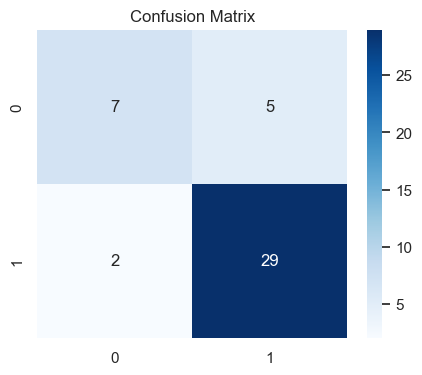

In [6]:
y_pred = xgb_model.predict(X_test_scaled)

print("\nAccuracy:", accuracy_score(y_test, y_pred) * 100, "%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


# Important Graphs

Work Experience vs Placement

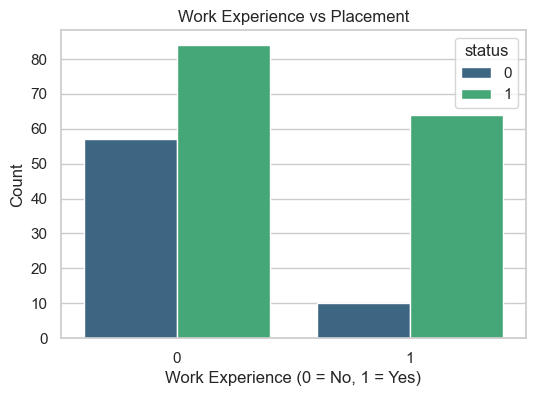

In [7]:
plt.figure(figsize=(6,4))
sns.countplot(x='workex', hue='status', data=df, palette='viridis')
plt.title("Work Experience vs Placement")
plt.xlabel("Work Experience (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()


Degree Percentage vs Placement

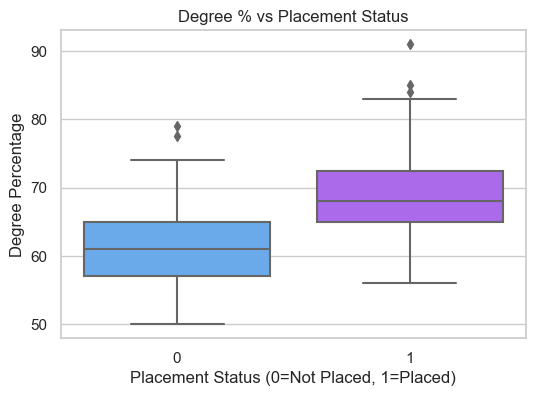

In [8]:
plt.figure(figsize=(6,4))
sns.boxplot(x='status', y='degree_p', data=df, palette='cool')
plt.title("Degree % vs Placement Status")
plt.xlabel("Placement Status (0=Not Placed, 1=Placed)")
plt.ylabel("Degree Percentage")
plt.show()


MBA Specialisation vs Placement

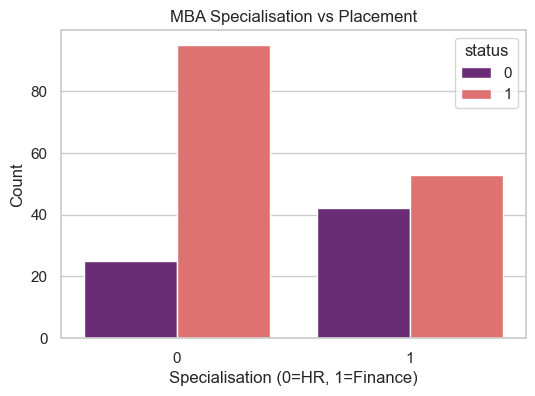

In [9]:
plt.figure(figsize=(6,4))
sns.countplot(x='specialisation', hue='status', data=df, palette='magma')
plt.title("MBA Specialisation vs Placement")
plt.xlabel("Specialisation (0=HR, 1=Finance)")
plt.ylabel("Count")
plt.show()


Feature Importance

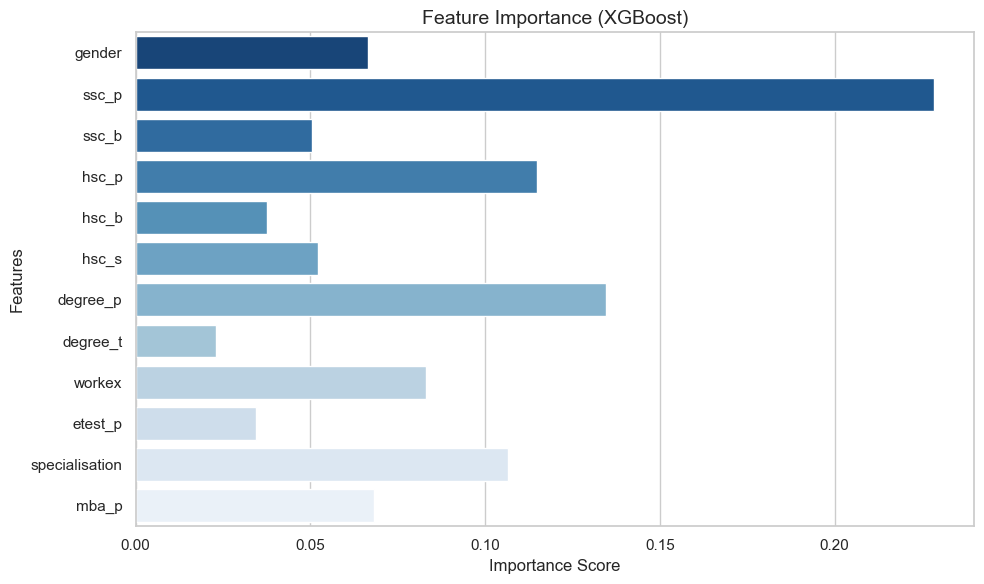

In [12]:
importances = xgb_model.feature_importances_
try:
    features = X.columns
except:
    features = [f"Feature_{i}" for i in range(len(importances))]

plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=features, palette="Blues_r")

plt.title("Feature Importance (XGBoost)", fontsize=14)
plt.xlabel("Importance Score", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.tight_layout()
plt.show()


Predict for a New Student

In [13]:
new_student = pd.DataFrame({
    'gender':[1],           
    'ssc_p':[82],           
    'ssc_b':[1],            
    'hsc_p':[78],           
    'hsc_b':[1],            
    'hsc_s':[1],           
    'degree_p':[75],        
    'degree_t':[1],        
    'workex':[1],           
    'etest_p':[85],         
    'specialisation':[1],   
    'mba_p':[72]           
})

new_scaled = scaler.transform(new_student)
pred_prob = xgb_model.predict_proba(new_scaled)[0][1]
pred_class = xgb_model.predict(new_scaled)[0]

print(f"\nPlacement Probability: {pred_prob*100:.2f}%")
print("Predicted Status:", "Placed" if pred_class==1 else "Not Placed")



Placement Probability: 99.04%
Predicted Status: Placed
